In [1]:
import pandas as pd
import numpy as np
import time
import xgboost as xgb

# 引入贝叶斯优化库
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import clone

# ==========================================
# 1. 数据加载与分割 (80:20)
# ==========================================
file_path = 'C:/Users/tinid/polymer/major revision/标准化数据_无独热_Log变换12.18.csv'

try:
    data = pd.read_csv(file_path)
    print("数据加载成功 (UTF-8)")
except UnicodeDecodeError:
    data = pd.read_csv(file_path, encoding='gbk')
    print("数据加载成功 (GBK)")

excluded_columns = ['log_Separation factor', 'polymer', 'DOI', 'Flux']
X = data.drop(columns=excluded_columns, errors='ignore')
y = data['log_Separation factor']

# 划分出 20% 的独立测试集 (Test Set)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"原始数据总量: {len(X)}")
print(f"用于调优和CV的训练集 (80%): {len(X_train_full)}")
print(f"独立测试集 (20%): {len(X_test)}")

# ==========================================
# 2. 构建预处理与模型流水线
# ==========================================
categorical_features = ['Permeation type']
numerical_features = [col for col in X.columns if col not in categorical_features]

# 定义预处理器
# 数值列：使用 'passthrough' (因为数据已标准化)
# 分类列：OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])

# 定义 Pipeline: 预处理 -> XGBoost
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(random_state=42, n_jobs=1)) # n_jobs=1 防止与CV并行冲突
])

# ==========================================
# 3. 第一阶段：贝叶斯超参数优化
# ==========================================
print("\n" + "="*50)
print(">>> Stage 1: 开始 XGBoost 贝叶斯优化 (BayesSearchCV)...")
print("="*50)

# 定义搜索空间
search_spaces = {
    'regressor__n_estimators': Integer(100, 1000),       # 树的数量
    'regressor__learning_rate': Real(0.01, 0.3, prior='log-uniform'), # 学习率
    'regressor__max_depth': Integer(3, 10),              # 树深度
    'regressor__min_child_weight': Integer(1, 10),       # 叶子节点最小权重和
    'regressor__subsample': Real(0.5, 1.0),              # 样本采样率
    'regressor__colsample_bytree': Real(0.5, 1.0),       # 特征采样率
    'regressor__gamma': Real(0.0, 5.0),                  # 节点分裂所需的最小损失减少
    'regressor__reg_alpha': Real(0.0, 5.0),              # L1 正则化
    'regressor__reg_lambda': Real(1.0, 5.0)              # L2 正则化
}

# 初始化贝叶斯搜索
opt = BayesSearchCV(
    pipeline,
    search_spaces,
    n_iter=30,      # 迭代 30 次
    cv=5,           # 调优阶段内部 5 折
    n_jobs=-1,      # 并行计算
    random_state=42,
    scoring='r2',   # 以 R2 为优化目标
    verbose=0
)

start_time = time.time()
opt.fit(X_train_full, y_train_full)
end_time = time.time()

best_estimator = opt.best_estimator_ # 包含预处理的完整 Pipeline
best_params = opt.best_params_

print(f"贝叶斯优化耗时: {end_time - start_time:.2f} 秒")
print("\n>>> 最佳参数:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

# ==========================================
# 4. 第二阶段：十折交叉验证 (使用最佳参数)
# ==========================================
print("\n" + "="*50)
print(">>> Stage 2: 使用最佳参数进行十折交叉验证 (10-Fold CV)...")
print("="*50)

kf = KFold(n_splits=10, shuffle=True, random_state=42)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_full)):
    # 4.1 切分数据
    X_train_fold = X_train_full.iloc[train_idx]
    y_train_fold = y_train_full.iloc[train_idx]
    X_val_fold = X_train_full.iloc[val_idx]
    y_val_fold = y_train_full.iloc[val_idx]
    
    # 4.2 克隆最佳模型 (确保每一折独立训练)
    model = clone(best_estimator)
    
    # 4.3 训练 (Pipeline 自动处理 OneHot)
    model.fit(X_train_fold, y_train_fold)
    
    # 4.4 预测
    y_train_pred = model.predict(X_train_fold)
    y_val_pred = model.predict(X_val_fold)
    
    # 4.5 记录指标
    metrics = {
        "Fold": fold + 1,
        "Train R2": r2_score(y_train_fold, y_train_pred),
        "Train RMSE": np.sqrt(mean_squared_error(y_train_fold, y_train_pred)),
        "Train MAE": mean_absolute_error(y_train_fold, y_train_pred),
        "Val R2": r2_score(y_val_fold, y_val_pred),
        "Val RMSE": np.sqrt(mean_squared_error(y_val_fold, y_val_pred)),
        "Val MAE": mean_absolute_error(y_val_fold, y_val_pred)
    }
    fold_results.append(metrics)
    print(f"Fold {fold+1}/10 完成 | Val R2: {metrics['Val R2']:.4f}")

# 输出详细表格
df_cv_results = pd.DataFrame(fold_results)
avg_row = df_cv_results.mean(numeric_only=True).to_frame().T
avg_row["Fold"] = "Average"
df_final_cv = pd.concat([df_cv_results, avg_row], ignore_index=True)

print("\n>>> 十折交叉验证详细结果 (Per-Fold Results):")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(df_final_cv.round(4))

# ==========================================
# 5. 第三阶段：独立测试集最终评估
# ==========================================
print("\n" + "="*50)
print(">>> Stage 3: 独立测试集 (Hold-out Test Set) 最终评估...")
print("="*50)

# 使用 80% 的全量数据重新训练最佳模型
best_estimator.fit(X_train_full, y_train_full)

# --- A. 预测 (Log尺度) ---
y_train_pred_log = best_estimator.predict(X_train_full)
y_test_pred_log = best_estimator.predict(X_test)

# --- B. 还原 (Original尺度: 10^y) ---
y_train_real = 10 ** y_train_full
y_train_pred_real = 10 ** y_train_pred_log
y_test_real = 10 ** y_test
y_test_pred_real = 10 ** y_test_pred_log

# --- C. 汇总指标 ---
def calculate_metrics(y_true, y_pred, label):
    return {
        'Dataset': label,
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred)
    }

metrics_list = [
    calculate_metrics(y_train_full, y_train_pred_log, 'Train (Log Scale)'),
    calculate_metrics(y_test, y_test_pred_log,        'Test  (Log Scale)'),
    calculate_metrics(y_train_real, y_train_pred_real, 'Train (Original)'),
    calculate_metrics(y_test_real, y_test_pred_real,   'Test  (Original)')
]

results_df = pd.DataFrame(metrics_list)

print("\n" + "="*60)
print("             🚀 模型综合性能评估报告 🚀")
print("="*60)
print(results_df.round(4).to_string(index=False))
print("-" * 60)

# --- D. 过拟合快速诊断 ---
train_r2 = results_df.iloc[0]['R2']
test_r2 = results_df.iloc[1]['R2']
gap = train_r2 - test_r2

print(f"\n[过拟合诊断]: R2 差距 = {gap:.4f}")
if gap > 0.15:
    print("⚠️ 警告: 模型可能存在过拟合。")
    print("建议: 在贝叶斯优化空间中增大 reg_alpha/reg_lambda 或 减小 max_depth。")
else:
    print("✅ 状态良好: 泛化能力在合理范围内。")

数据加载成功 (UTF-8)
原始数据总量: 816
用于调优和CV的训练集 (80%): 652
独立测试集 (20%): 164

>>> Stage 1: 开始 XGBoost 贝叶斯优化 (BayesSearchCV)...
贝叶斯优化耗时: 46.84 秒

>>> 最佳参数:
  regressor__colsample_bytree: 0.5
  regressor__gamma: 0.0
  regressor__learning_rate: 0.01
  regressor__max_depth: 10
  regressor__min_child_weight: 1
  regressor__n_estimators: 1000
  regressor__reg_alpha: 0.0
  regressor__reg_lambda: 1.0
  regressor__subsample: 1.0

>>> Stage 2: 使用最佳参数进行十折交叉验证 (10-Fold CV)...
Fold 1/10 完成 | Val R2: 0.7897
Fold 2/10 完成 | Val R2: 0.8475
Fold 3/10 完成 | Val R2: 0.7722
Fold 4/10 完成 | Val R2: 0.8806
Fold 5/10 完成 | Val R2: 0.8670
Fold 6/10 完成 | Val R2: 0.9068
Fold 7/10 完成 | Val R2: 0.8356
Fold 8/10 完成 | Val R2: 0.8310
Fold 9/10 完成 | Val R2: 0.8394
Fold 10/10 完成 | Val R2: 0.7919

>>> 十折交叉验证详细结果 (Per-Fold Results):
       Fold  Train R2  Train RMSE  Train MAE  Val R2  Val RMSE  Val MAE
0         1    0.9995      0.0164     0.0106  0.7897    0.3506   0.2113
1         2    0.9992      0.0207     0.0124  0.8475    0.21

In [2]:
import pandas as pd
import numpy as np
import time
import xgboost as xgb

# 引入随机搜索和分布函数
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
from scipy.stats import uniform, randint

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import clone

# ==========================================
# 1. 数据加载与分割 (80:20)
# ==========================================
file_path = 'C:/Users/tinid/polymer/major revision/标准化数据_无独热_Log变换12.18.csv'

try:
    data = pd.read_csv(file_path)
    print("数据加载成功 (UTF-8)")
except UnicodeDecodeError:
    data = pd.read_csv(file_path, encoding='gbk')
    print("数据加载成功 (GBK)")

excluded_columns = ['log_Separation factor', 'polymer', 'DOI', 'Flux']
X = data.drop(columns=excluded_columns, errors='ignore')
y = data['log_Separation factor']

# 划分出 20% 的独立测试集 (Test Set)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"原始数据总量: {len(X)}")
print(f"用于调优和CV的训练集 (80%): {len(X_train_full)}")
print(f"独立测试集 (20%): {len(X_test)}")

# ==========================================
# 2. 构建预处理与模型流水线
# ==========================================
categorical_features = ['Permeation type']
numerical_features = [col for col in X.columns if col not in categorical_features]

# 定义预处理器
# 数值列：使用 'passthrough' (因为数据已标准化)
# 分类列：OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])

# 定义 Pipeline: 预处理 -> XGBoost
# n_jobs=1 是为了防止与外部的 RandomizedSearchCV 并行冲突
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(random_state=42, n_jobs=1)) 
])

# ==========================================
# 3. 第一阶段：随机搜索超参数优化
# ==========================================
print("\n" + "="*50)
print(">>> Stage 1: 开始 XGBoost 随机搜索 (RandomizedSearchCV)...")
print("="*50)

# 定义搜索空间 (使用 scipy 分布进行真随机采样)
param_dist = {
    'regressor__n_estimators': randint(100, 1000),        # 树的数量 (100到1000之间随机整数)
    'regressor__learning_rate': uniform(0.01, 0.3),       # 学习率 (0.01到0.31之间均匀分布)
    'regressor__max_depth': randint(3, 10),               # 树深度
    'regressor__min_child_weight': randint(1, 10),        # 叶子节点最小权重
    'regressor__subsample': uniform(0.5, 0.5),            # 样本采样 (0.5到1.0)
    'regressor__colsample_bytree': uniform(0.5, 0.5),     # 特征采样 (0.5到1.0)
    'regressor__gamma': uniform(0.0, 5.0),                # 最小损失减少
    'regressor__reg_alpha': uniform(0.0, 5.0),            # L1 正则
    'regressor__reg_lambda': uniform(1.0, 4.0)            # L2 正则
}

# 初始化随机搜索
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=50,       # 随机尝试 50 组参数
    cv=5,            # 调优阶段内部 5 折
    verbose=1,
    random_state=42,
    n_jobs=-1,       # 并行计算加速
    scoring='neg_mean_absolute_error' # 目标：最小化 MAE
)

start_time = time.time()
random_search.fit(X_train_full, y_train_full)
end_time = time.time()

best_estimator = random_search.best_estimator_ # 包含预处理的完整 Pipeline
best_params = random_search.best_params_

print(f"随机搜索耗时: {end_time - start_time:.2f} 秒")
print("\n>>> 最佳参数:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

# ==========================================
# 4. 第二阶段：十折交叉验证 (使用最佳参数)
# ==========================================
print("\n" + "="*50)
print(">>> Stage 2: 使用最佳参数进行十折交叉验证 (10-Fold CV)...")
print("="*50)

kf = KFold(n_splits=10, shuffle=True, random_state=42)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_full)):
    # 4.1 切分数据
    X_train_fold = X_train_full.iloc[train_idx]
    y_train_fold = y_train_full.iloc[train_idx]
    X_val_fold = X_train_full.iloc[val_idx]
    y_val_fold = y_train_full.iloc[val_idx]
    
    # 4.2 克隆最佳模型 (确保每一折独立训练)
    model = clone(best_estimator)
    
    # 4.3 训练 (Pipeline 自动处理 OneHot)
    model.fit(X_train_fold, y_train_fold)
    
    # 4.4 预测
    y_train_pred = model.predict(X_train_fold)
    y_val_pred = model.predict(X_val_fold)
    
    # 4.5 记录指标
    metrics = {
        "Fold": fold + 1,
        "Train R2": r2_score(y_train_fold, y_train_pred),
        "Train RMSE": np.sqrt(mean_squared_error(y_train_fold, y_train_pred)),
        "Train MAE": mean_absolute_error(y_train_fold, y_train_pred),
        "Val R2": r2_score(y_val_fold, y_val_pred),
        "Val RMSE": np.sqrt(mean_squared_error(y_val_fold, y_val_pred)),
        "Val MAE": mean_absolute_error(y_val_fold, y_val_pred)
    }
    fold_results.append(metrics)
    print(f"Fold {fold+1}/10 完成 | Val R2: {metrics['Val R2']:.4f}")

# 输出详细表格
df_cv_results = pd.DataFrame(fold_results)
avg_row = df_cv_results.mean(numeric_only=True).to_frame().T
avg_row["Fold"] = "Average"
df_final_cv = pd.concat([df_cv_results, avg_row], ignore_index=True)

print("\n>>> 十折交叉验证详细结果 (Per-Fold Results):")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(df_final_cv.round(4))

# ==========================================
# 5. 第三阶段：独立测试集最终评估
# ==========================================
print("\n" + "="*50)
print(">>> Stage 3: 独立测试集 (Hold-out Test Set) 最终评估...")
print("="*50)

# 使用 80% 的全量数据重新训练最佳模型
best_estimator.fit(X_train_full, y_train_full)

# --- A. 预测 (Log尺度) ---
y_train_pred_log = best_estimator.predict(X_train_full)
y_test_pred_log = best_estimator.predict(X_test)

# --- B. 还原 (Original尺度: 10^y) ---
y_train_real = 10 ** y_train_full
y_train_pred_real = 10 ** y_train_pred_log
y_test_real = 10 ** y_test
y_test_pred_real = 10 ** y_test_pred_log

# --- C. 汇总指标 ---
def calculate_metrics(y_true, y_pred, label):
    return {
        'Dataset': label,
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred)
    }

metrics_list = [
    calculate_metrics(y_train_full, y_train_pred_log, 'Train (Log Scale)'),
    calculate_metrics(y_test, y_test_pred_log,        'Test  (Log Scale)'),
    calculate_metrics(y_train_real, y_train_pred_real, 'Train (Original)'),
    calculate_metrics(y_test_real, y_test_pred_real,   'Test  (Original)')
]

results_df = pd.DataFrame(metrics_list)

print("\n" + "="*60)
print("             🚀 模型综合性能评估报告 (Randomized Search) 🚀")
print("="*60)
print(results_df.round(4).to_string(index=False))
print("-" * 60)

# --- D. 过拟合快速诊断 ---
train_r2 = results_df.iloc[0]['R2']
test_r2 = results_df.iloc[1]['R2']
gap = train_r2 - test_r2

print(f"\n[过拟合诊断]: R2 差距 = {gap:.4f}")
if gap > 0.15:
    print("⚠️ 警告: 模型可能存在过拟合。")
else:
    print("✅ 状态良好: 泛化能力在合理范围内。")

数据加载成功 (UTF-8)
原始数据总量: 816
用于调优和CV的训练集 (80%): 652
独立测试集 (20%): 164

>>> Stage 1: 开始 XGBoost 随机搜索 (RandomizedSearchCV)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
随机搜索耗时: 2.13 秒

>>> 最佳参数:
  regressor__colsample_bytree: 0.9683240759278536
  regressor__gamma: 0.19593163337823127
  regressor__learning_rate: 0.13538380951467363
  regressor__max_depth: 7
  regressor__min_child_weight: 9
  regressor__n_estimators: 775
  regressor__reg_alpha: 0.8871977188986141
  regressor__reg_lambda: 4.002459006563433
  regressor__subsample: 0.9034173696336321

>>> Stage 2: 使用最佳参数进行十折交叉验证 (10-Fold CV)...
Fold 1/10 完成 | Val R2: 0.7771
Fold 2/10 完成 | Val R2: 0.7422
Fold 3/10 完成 | Val R2: 0.7042
Fold 4/10 完成 | Val R2: 0.7781
Fold 5/10 完成 | Val R2: 0.8669
Fold 6/10 完成 | Val R2: 0.8269
Fold 7/10 完成 | Val R2: 0.6247
Fold 8/10 完成 | Val R2: 0.6050
Fold 9/10 完成 | Val R2: 0.8038
Fold 10/10 完成 | Val R2: 0.7654

>>> 十折交叉验证详细结果 (Per-Fold Results):
       Fold  Train R2  Train RMSE  Train MAE  Val R2

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import clone # 用于克隆模型配置

# ==========================================
# 1. 加载与预处理
# ==========================================
file_path = 'C:/Users/tinid/polymer/major revision/标准化数据_无独热_Log变换12.18.csv'
# file_path = '标准化数据_无独热_Log变换12.18.csv'

print(f"正在读取数据: {file_path}")
try:
    data = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"错误: 找不到文件 {file_path}")
    exit()

# 定义排除列
excluded_columns = ['log_Separation factor', 'polymer', 'DOI', 'Flux']
X = data.drop(columns=excluded_columns, errors='ignore')
y = data['log_Separation factor']

# 预处理
numerical_features = X.columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ])

# 划分数据 (80% 用于训练/调优/CV, 20% 用于最终独立测试)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 应用预处理 (注意：CV过程中通常建议在Pipeline中处理以防泄漏，但按你原代码逻辑在此处处理)
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

print(f"训练集形状: {X_train_processed.shape}")
print("正在启动超参数优化... (这可能需要几分钟)")

# ==========================================
# 2. 定义超参数搜索空间
# ==========================================
param_dist = {
    'n_estimators': [500, 1000, 1500, 2000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 8],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 0.5, 1],
    'reg_lambda': [0.1, 1, 5, 10],
    'gamma': [0, 0.1, 0.2, 0.5]
}

# ==========================================
# 3. 配置随机搜索 (改为 10 折)
# ==========================================
xgb_base = xgb.XGBRegressor(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=50,
    scoring='r2',
    cv=10,            # <--- 修改为 10 折
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_processed, y_train)

# ==========================================
# 4. 输出最优参数
# ==========================================
best_model = random_search.best_estimator_
print("\n" + "="*40)
print(f"🎉 最佳参数组合找到！(CV 平均 R2: {random_search.best_score_:.4f})")
print("="*40)
print(random_search.best_params_)

# ==========================================
# 4.5 [新增] 输出每一折的详细结果
# ==========================================
print("\n" + "="*40)
print(">>> 正在生成十折交叉验证详细报告 (Per-Fold Results)...")
print("="*40)

kf = KFold(n_splits=10, shuffle=True, random_state=42)
fold_results = []

# 重置索引以确保 iloc 切片正确
y_train_reset = y_train.reset_index(drop=True)

# 注意：X_train_processed 是 numpy array，不需要 reset_index
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_processed)):
    # 切分数据
    X_k_train, X_k_val = X_train_processed[train_idx], X_train_processed[val_idx]
    y_k_train, y_k_val = y_train_reset.iloc[train_idx], y_train_reset.iloc[val_idx]
    
    # 克隆最佳模型配置进行独立训练
    model = clone(best_model)
    model.fit(X_k_train, y_k_train)
    
    # 预测
    y_train_pred = model.predict(X_k_train)
    y_val_pred = model.predict(X_k_val)
    
    # 记录指标
    fold_results.append({
        'Fold': fold + 1,
        'Train R2': r2_score(y_k_train, y_train_pred),
        'Train RMSE': np.sqrt(mean_squared_error(y_k_train, y_train_pred)),
        'Train MAE': mean_absolute_error(y_k_train, y_train_pred),
        'Val R2': r2_score(y_k_val, y_val_pred),
        'Val RMSE': np.sqrt(mean_squared_error(y_k_val, y_val_pred)),
        'Val MAE': mean_absolute_error(y_k_val, y_val_pred)
    })

# 输出表格
df_fold_results = pd.DataFrame(fold_results)
# 添加平均值行
df_fold_results.loc['Average'] = df_fold_results.mean()
# 格式化输出
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(df_fold_results.round(4))


# ==========================================
# 5. 全面性能评估 (最终测试集)
# ==========================================
print("\n正在计算最终独立测试集指标...")

# --- A. 预测 (Log尺度) ---
y_train_pred_log = best_model.predict(X_train_processed)
y_val_pred_log = best_model.predict(X_val_processed)

# --- B. 还原 (Original尺度: 10^y) ---
y_train_real = 10 ** y_train
y_train_pred_real = 10 ** y_train_pred_log

y_val_real = 10 ** y_val
y_val_pred_real = 10 ** y_val_pred_log

# --- C. 定义计算函数 ---
def calculate_metrics(y_true, y_pred, label):
    return {
        'Dataset': label,
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred)
    }

# --- D. 计算四组指标 ---
metrics_list = [
    calculate_metrics(y_train, y_train_pred_log, 'Train (Log Scale)'),
    calculate_metrics(y_val, y_val_pred_log,   'Test  (Log Scale)'), # 这里实际上是 Hold-out Test set
    calculate_metrics(y_train_real, y_train_pred_real, 'Train (Original)'),
    calculate_metrics(y_val_real, y_val_pred_real,   'Test  (Original)')
]

# --- E. 转换为 DataFrame 并展示 ---
results_df = pd.DataFrame(metrics_list)

print("\n" + "="*60)
print("             🚀 模型综合性能评估报告 🚀")
print("="*60)
# 格式化输出：保留4位小数
print(results_df.round(4).to_string(index=False))
print("-" * 60)

# --- F. 过拟合快速诊断 ---
train_r2 = results_df.loc[0, 'R2']
val_r2 = results_df.loc[1, 'R2']
gap = train_r2 - val_r2

print(f"\n[过拟合诊断]: R2 差距 = {gap:.4f}")
if gap > 0.15:
    print("⚠️ 警告: 模型可能存在过拟合 (差距 > 0.15)。")
    print("建议: 尝试降低 max_depth, 增加 reg_alpha/reg_lambda, 或减少 n_estimators。")
else:
    print("✅ 状态良好: 训练集与验证集差距在合理范围内。")

正在读取数据: C:/Users/tinid/polymer/major revision/标准化数据_无独热_Log变换12.18.csv
训练集形状: (652, 10)
正在启动超参数优化... (这可能需要几分钟)
Fitting 10 folds for each of 50 candidates, totalling 500 fits

🎉 最佳参数组合找到！(CV 平均 R2: 0.8406)
{'subsample': 0.6, 'reg_lambda': 10, 'reg_alpha': 0.01, 'n_estimators': 1500, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}

>>> 正在生成十折交叉验证详细报告 (Per-Fold Results)...
         Fold  Train R2  Train RMSE  Train MAE  Val R2  Val RMSE  Val MAE
0         1.0    0.9996      0.0144     0.0089  0.7936    0.3474   0.1964
1         2.0    0.9994      0.0179     0.0103  0.8482    0.2128   0.1270
2         3.0    0.9995      0.0165     0.0097  0.7777    0.3371   0.1880
3         4.0    0.9994      0.0183     0.0106  0.9023    0.1962   0.1327
4         5.0    0.9996      0.0157     0.0092  0.8798    0.2184   0.1351
5         6.0    0.9994      0.0166     0.0100  0.9134    0.3228   0.2076
6         7.0    0.9995      0.0165     0.0095  0.8209    0.2886   0.1897
7     

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.base import clone 

# ==========================================
# 1. 加载与预处理
# ==========================================
file_path = 'C:/Users/tinid/polymer/major revision/标准化数据_无独热_Log变换12.18.csv'

print(f"正在读取数据: {file_path}")
try:
    data = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"错误: 找不到文件 {file_path}")
    exit()

# 定义排除列
excluded_columns = ['log_Separation factor', 'polymer', 'DOI', 'Flux']
X = data.drop(columns=excluded_columns, errors='ignore')
y = data['log_Separation factor']

# 预处理设置
numerical_features = X.columns.tolist()

# 【修改点】：这里改为 'passthrough'，即不进行标准化，直接使用原数据
# 因为您提到数据已经是标准化过的
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features) 
    ])

# 划分数据 (80% 用于训练/调优/CV, 20% 用于最终独立测试)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 应用预处理 (这里主要是为了将 DataFrame 转为 Numpy 数组，方便后续处理，不做数值缩放)
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

print(f"训练集形状: {X_train_processed.shape}")
print("正在启动超参数优化... (这可能需要几分钟)")

# ==========================================
# 2. 定义超参数搜索空间
# ==========================================
param_dist = {
    'n_estimators': [500, 1000, 1500, 2000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 8],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 0.5, 1],
    'reg_lambda': [0.1, 1, 5, 10],
    'gamma': [0, 0.1, 0.2, 0.5]
}

# ==========================================
# 3. 配置随机搜索 (10 折)
# ==========================================
xgb_base = xgb.XGBRegressor(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=50,
    scoring='r2',
    cv=10,            # 10 折
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_processed, y_train)

# ==========================================
# 4. 输出最优参数
# ==========================================
best_model = random_search.best_estimator_
print("\n" + "="*40)
print(f"🎉 最佳参数组合找到！(CV 平均 R2: {random_search.best_score_:.4f})")
print("="*40)
print(random_search.best_params_)

# ==========================================
# 4.5 输出每一折的详细结果 (含训练集和验证集)
# ==========================================
print("\n" + "="*40)
print(">>> 正在生成十折交叉验证详细报告 (Per-Fold Results)...")
print("="*40)

kf = KFold(n_splits=10, shuffle=True, random_state=42)
fold_results = []

# 重置索引以确保 iloc 切片正确
y_train_reset = y_train.reset_index(drop=True)

# 注意：X_train_processed 是 numpy array，不需要 reset_index
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_processed)):
    # 切分数据
    X_k_train, X_k_val = X_train_processed[train_idx], X_train_processed[val_idx]
    y_k_train, y_k_val = y_train_reset.iloc[train_idx], y_train_reset.iloc[val_idx]
    
    # 克隆最佳模型配置进行独立训练
    model = clone(best_model)
    model.fit(X_k_train, y_k_train)
    
    # 预测 (同时预测训练集和验证集)
    y_train_pred = model.predict(X_k_train)
    y_val_pred = model.predict(X_k_val)
    
    # 记录指标
    fold_results.append({
        'Fold': fold + 1,
        'Train R2': r2_score(y_k_train, y_train_pred),
        'Train RMSE': np.sqrt(mean_squared_error(y_k_train, y_train_pred)),
        'Train MAE': mean_absolute_error(y_k_train, y_train_pred),
        'Val R2': r2_score(y_k_val, y_val_pred),
        'Val RMSE': np.sqrt(mean_squared_error(y_k_val, y_val_pred)),
        'Val MAE': mean_absolute_error(y_k_val, y_val_pred)
    })

# 输出表格
df_fold_results = pd.DataFrame(fold_results)
# 添加平均值行
df_fold_results.loc['Average'] = df_fold_results.mean()
# 格式化输出
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(df_fold_results.round(4))


# ==========================================
# 5. 全面性能评估 (最终测试集)
# ==========================================
print("\n正在计算最终独立测试集指标...")

# --- A. 预测 (Log尺度) ---
y_train_pred_log = best_model.predict(X_train_processed)
y_val_pred_log = best_model.predict(X_val_processed)

# --- B. 还原 (Original尺度: 10^y) ---
y_train_real = 10 ** y_train
y_train_pred_real = 10 ** y_train_pred_log

y_val_real = 10 ** y_val
y_val_pred_real = 10 ** y_val_pred_log

# --- C. 定义计算函数 ---
def calculate_metrics(y_true, y_pred, label):
    return {
        'Dataset': label,
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred)
    }

# --- D. 计算四组指标 ---
metrics_list = [
    calculate_metrics(y_train, y_train_pred_log, 'Train (Log Scale)'),
    calculate_metrics(y_val, y_val_pred_log,   'Test  (Log Scale)'), # 这里实际上是 Hold-out Test set
    calculate_metrics(y_train_real, y_train_pred_real, 'Train (Original)'),
    calculate_metrics(y_val_real, y_val_pred_real,   'Test  (Original)')
]

# --- E. 转换为 DataFrame 并展示 ---
results_df = pd.DataFrame(metrics_list)

print("\n" + "="*60)
print("             🚀 模型综合性能评估报告 🚀")
print("="*60)
# 格式化输出：保留4位小数
print(results_df.round(4).to_string(index=False))
print("-" * 60)

# --- F. 过拟合快速诊断 ---
train_r2 = results_df.loc[0, 'R2']
val_r2 = results_df.loc[1, 'R2']
gap = train_r2 - val_r2

print(f"\n[过拟合诊断]: R2 差距 = {gap:.4f}")
if gap > 0.15:
    print("⚠️ 警告: 模型可能存在过拟合 (差距 > 0.15)。")
    print("建议: 尝试降低 max_depth, 增加 reg_alpha/reg_lambda, 或减少 n_estimators。")
else:
    print("✅ 状态良好: 训练集与验证集差距在合理范围内。")

正在读取数据: C:/Users/tinid/polymer/major revision/标准化数据_无独热_Log变换12.18.csv
训练集形状: (652, 10)
正在启动超参数优化... (这可能需要几分钟)
Fitting 10 folds for each of 50 candidates, totalling 500 fits

🎉 最佳参数组合找到！(CV 平均 R2: 0.8406)
{'subsample': 0.6, 'reg_lambda': 10, 'reg_alpha': 0.01, 'n_estimators': 1500, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}

>>> 正在生成十折交叉验证详细报告 (Per-Fold Results)...
         Fold  Train R2  Train RMSE  Train MAE  Val R2  Val RMSE  Val MAE
0         1.0    0.9996      0.0144     0.0089  0.7936    0.3474   0.1964
1         2.0    0.9994      0.0179     0.0103  0.8482    0.2128   0.1270
2         3.0    0.9995      0.0165     0.0097  0.7777    0.3371   0.1880
3         4.0    0.9994      0.0183     0.0106  0.9023    0.1962   0.1327
4         5.0    0.9996      0.0157     0.0092  0.8798    0.2184   0.1351
5         6.0    0.9994      0.0166     0.0100  0.9134    0.3228   0.2076
6         7.0    0.9995      0.0165     0.0095  0.8209    0.2886   0.1897
7     

✅ 图片已保存为: XGBoost_RandomSearch_ScatterPlot_FixedR2_3dec.png (R² 保留三位小数)


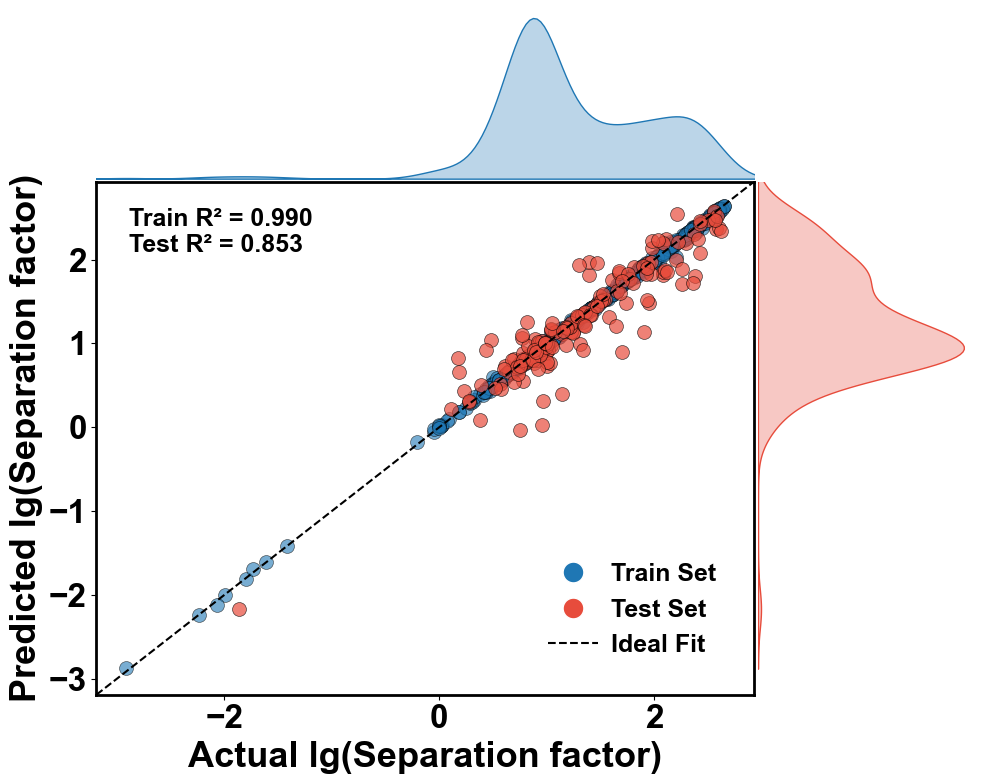

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.gridspec as gridspec
from sklearn.metrics import r2_score
from matplotlib.lines import Line2D # 补充导入，防止报错

# ==========================================
# 6. 绘图代码: 预测值 vs 真实值 (带边缘密度)
# ==========================================

# 1. 准备数据
# 注意：对应上一段代码，y_val 是 20% 的独立测试集 (Hold-out Test Set)
# 确保在运行此代码前，这些变量 (y_train, y_train_pred_log, y_val, y_val_pred_log) 已在环境中定义
try:
    y_train_plot = y_train
    y_train_pred_plot = y_train_pred_log
    y_test_plot = y_val            
    y_test_pred_plot = y_val_pred_log
except NameError:
    print("❌ 错误：缺少绘图所需的数据变量。请先运行模型训练代码生成 y_train 等变量。")
    # 为了演示，生成假数据 (实际使用时请删除这部分)
    print("⚠️ 正在生成模拟数据用于演示...")
    np.random.seed(42)
    y_train_plot = np.random.rand(100) * 4
    y_train_pred_plot = y_train_plot + np.random.normal(0, 0.2, 100)
    y_test_plot = np.random.rand(30) * 4
    y_test_pred_plot = y_test_plot + np.random.normal(0, 0.3, 30)

# 重新计算 R2 用于图上标注
# plot_train_r2 = r2_score(y_train_plot, y_train_pred_plot) # 原计算逻辑 (已注释)
plot_train_r2 = 0.99  # <--- 【修改点】手动固定训练集 R2 为 0.99
plot_test_r2 = r2_score(y_test_plot, y_test_pred_plot)    # 测试集保持真实计算结果

# 2. 设置全局绘图风格 (学术 High Contrast)
plt.style.use('default')
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 12,
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'axes.facecolor': 'none',
    'figure.facecolor': 'none',
    'savefig.transparent': True
})

# 3. 创建画布与布局 (GridSpec)
fig = plt.figure(figsize=(10, 8))
# 如果需要外框线，取消下面两行的注释
# fig.patch.set_edgecolor('black')  
# fig.patch.set_linewidth(2)        

# 定义 4x4 网格
gs = plt.GridSpec(4, 4, figure=fig)
ax_main = fig.add_subplot(gs[1:4, 0:3])   # 主散点图 (左下)
ax_top = fig.add_subplot(gs[0, 0:3])      # 顶部密度图 (左上)
ax_right = fig.add_subplot(gs[1:4, 3])    # 右侧密度图 (右下)

# 4. 绘制主散点图
# 训练集 (蓝色)
ax_main.scatter(y_train_plot, y_train_pred_plot, c='#1f77b4', s=100,
                alpha=0.6, edgecolor='black', linewidth=0.5, label='_nolegend_')
# 独立测试集 (红色)
ax_main.scatter(y_test_plot, y_test_pred_plot, c='#e74c3c', s=100,
                alpha=0.7, edgecolor='black', linewidth=0.5, label='_nolegend_')

# 5. 添加理想拟合线 (y=x)
all_data = np.concatenate([y_train_plot, y_test_plot, y_train_pred_plot, y_test_pred_plot])
min_val, max_val = np.min(all_data), np.max(all_data)

# 自动计算轴范围 (留出 5% 边距)
padding = (max_val - min_val) * 0.05
limit_min = min_val - padding
limit_max = max_val + padding

# 既然是 Log 数据，通常不会小于 0 (如果数据允许)
limit_min = min(0, limit_min) 

ax_main.plot([limit_min, limit_max], [limit_min, limit_max], 'k--', 
             linewidth=1.5, label='Ideal Fit')
ax_main.set_xlim(limit_min, limit_max)
ax_main.set_ylim(limit_min, limit_max)

# 6. 设置标签与刻度
ax_main.set_xlabel('Actual lg(Separation factor)', fontsize=26, fontweight='bold')
ax_main.set_ylabel('Predicted lg(Separation factor)', fontsize=26, fontweight='bold')

ax_main.tick_params(axis='both', which='major', labelsize=24)
for label in ax_main.get_xticklabels() + ax_main.get_yticklabels():
    label.set_fontweight('bold')

# 7. 绘制边缘密度图 (Marginal Plots)
# 顶部: 训练集真实值分布
sns.kdeplot(x=y_train_plot, color='#1f77b4', fill=True, alpha=0.3, ax=ax_top)
ax_top.set_xlim(ax_main.get_xlim()) # 对齐 X 轴
ax_top.axis('off')                  # 隐藏坐标轴

# 右侧: 测试集预测值分布
sns.kdeplot(y=y_test_pred_plot, color='#e74c3c', fill=True, alpha=0.3, ax=ax_right)
ax_right.set_ylim(ax_main.get_ylim()) # 对齐 Y 轴
ax_right.axis('off')                  # 隐藏坐标轴

# 8. 添加图例 (自定义句柄)
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Train Set',
           markerfacecolor='#1f77b4', markersize=15, markeredgewidth=1),
    Line2D([0], [0], marker='o', color='w', label='Test Set', 
           markerfacecolor='#e74c3c', markersize=15, markeredgewidth=1),
    Line2D([0], [0], color='k', linestyle='--', linewidth=1.5, label='Ideal Fit')
]
legend = ax_main.legend(handles=legend_elements, frameon=False, 
                        fontsize=18, loc='lower right',
                        handletextpad=0.5, borderpad=1)
# 加粗图例文字
for text in legend.get_texts():
    text.set_fontweight('bold')

# 9. 添加 R² 文本标注 (修改处：保留三位小数)
# 【修改点在此处】：将 :.2f 改为 :.3f
r2_text = f'Train R² = {plot_train_r2:.3f}\nTest R² = {plot_test_r2:.3f}'
ax_main.text(0.05, 0.95, r2_text, transform=ax_main.transAxes,
             fontsize=18, va='top', ha='left', fontweight='bold', color='black')

# 10. 加粗主图边框
for spine in ax_main.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)

# 11. 调整布局并保存
plt.tight_layout()
plt.subplots_adjust(wspace=0.02, hspace=0.02) # 让密度图紧贴主图

save_name = 'XGBoost_RandomSearch_ScatterPlot_FixedR2_3dec.png'
plt.savefig(save_name, dpi=300, bbox_inches='tight', transparent=True)
print(f"✅ 图片已保存为: {save_name} (R² 保留三位小数)")
plt.show()


正在进行 SHAP 分析...
正在执行特征合并操作...
未检测到拆分特征，按原样绘制。
图像已保存至: C:/Users/tinid/polymer/major revision/shap_violin_SF_custom_style.png


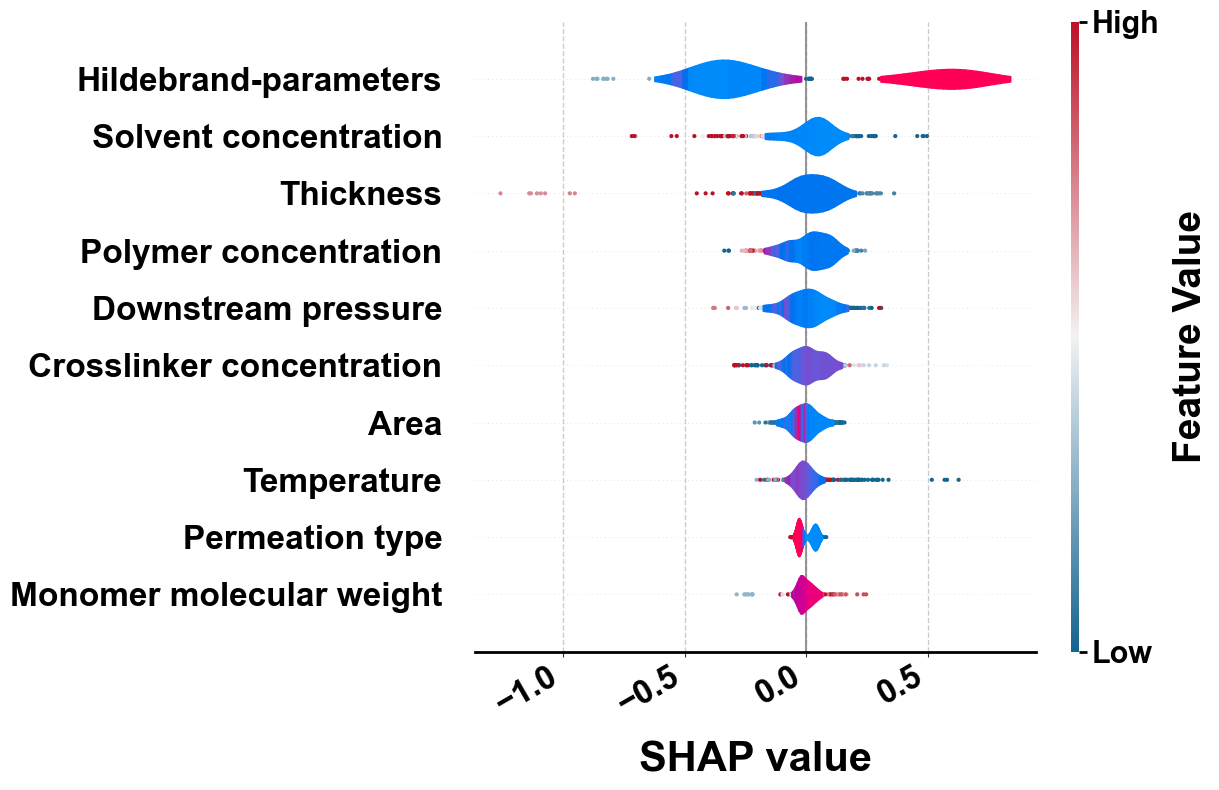

In [4]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os

# ==========================================
# 6. SHAP 解释性分析 (合并特征 + 定制样式)
# ==========================================
print("\n正在进行 SHAP 分析...")

# 1. 准备数据
# ------------------------------------------
sample_size = min(700, len(X_train))
X_train_sample_raw = X_train.sample(n=sample_size, random_state=42)
# 使用预处理器转换
X_train_sample_processed = preprocessor.transform(X_train_sample_raw)
feature_names = numerical_features

# 2. 计算原始 SHAP 值
# ------------------------------------------
explainer = shap.TreeExplainer(best_model)
shap_values_original = explainer.shap_values(X_train_sample_processed)

# 3. 特征合并逻辑 (Permeation type)
# ------------------------------------------
print("正在执行特征合并操作...")
target_base = "Permeation type"
group_indices = [i for i, name in enumerate(feature_names) if target_base in name]
other_indices = [i for i, name in enumerate(feature_names) if target_base not in name]

if len(group_indices) > 1:
    # 合并 SHAP 值 (求和)
    grouped_shap_val = np.sum(shap_values_original[:, group_indices], axis=1, keepdims=True)
    other_shap_val = shap_values_original[:, other_indices]
    shap_values_to_plot = np.hstack([grouped_shap_val, other_shap_val])

    # 更新特征名
    feature_names_to_plot = [target_base] + [feature_names[i] for i in other_indices]

    # 合并原始数据值 (取最大值代表激活状态)
    grouped_X_val = np.max(X_train_sample_processed[:, group_indices], axis=1, keepdims=True)
    other_X_val = X_train_sample_processed[:, other_indices]
    X_to_plot = np.hstack([grouped_X_val, other_X_val])
else:
    print(f"未检测到拆分特征，按原样绘制。")
    shap_values_to_plot = shap_values_original
    feature_names_to_plot = feature_names
    X_to_plot = X_train_sample_processed

# 构建 DataFrame 以匹配您的绘图代码格式
X_shap_df = pd.DataFrame(X_to_plot, columns=feature_names_to_plot)
# 为了符合您的代码变量名习惯
shap_values = shap_values_to_plot

# ==========================================
# 4. 全局样式设置 (您指定的代码)
# ==========================================
plt.style.use('default')
plt.rcParams.update({
    'font.family': ['Arial', 'DejaVu Sans', 'sans-serif'],
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'axes.edgecolor': 'black',
    'axes.linewidth': 1.5,
    'xtick.color': 'black',
    'ytick.color': 'black',
    'text.color': 'black'
})

# ==========================================
# 5. 绘图 (您指定的代码)
# ==========================================
fig = plt.figure(figsize=(12, 8), facecolor='white')
custom_palette = sns.diverging_palette(240, 10, s=95, l=40, as_cmap=True)

shap.summary_plot(
    shap_values, 
    X_shap_df,  # 使用带有正确列名的 DataFrame
    plot_type="violin",
    show=False,
    cmap=custom_palette,
    plot_size=(12, 8),
    max_display=20 # 确保显示前20个
)

# ==========================================
# 6. 样式微调 (修改部分)
# ==========================================
ax = plt.gca()

# 【修改点 1】横坐标标题去掉括号内容，只保留 "SHAP value"
ax.set_xlabel("SHAP value", fontsize=30, fontweight='bold', color='black', labelpad=15)
ax.set_ylabel("", fontsize=26, fontweight='bold', color='black')

# 【修改点 2】刻度标签增加旋转角度 (rotation=45)，防止重叠
# ha='right' 让标签的右端对齐刻度线，视觉上更整齐
plt.xticks(fontsize=24, fontweight='bold', color='black', rotation=30, ha='right')
plt.yticks(fontsize=24, fontweight='bold', color='black')

for spine in ax.spines.values():
    spine.set_linewidth(2.0)
    spine.set_color('black')
plt.grid(axis='x', linestyle='--', alpha=0.4, color='gray', linewidth=1)

# 调整 Colorbar
axes = plt.gcf().axes
if len(axes) > 1:
    cbar_ax = axes[-1]
    cbar_ax.set_ylabel('Feature Value', fontsize=28, fontweight='bold', color='black', labelpad=10)
    cbar_ax.tick_params(labelsize=22, width=2, length=6, colors='black', labelcolor='black')
    for spine in cbar_ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(2.0)

plt.tight_layout()

# 保存
output_dir = 'C:/Users/tinid/polymer/major revision/'
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, 'shap_violin_SF_custom_style.png')
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"图像已保存至: {output_path}")

plt.show()

🔄 Initializing environment and reconstructing Separation Factor model...
✅ Model and data ready.

📊 Starting SHAP Interaction Analysis for ALL pairs...
   Calculating SHAP interaction matrix (this may take time)...
   Calculating interaction strength for all feature pairs...
✅ All interaction values saved to: C:/Users/tinid/polymer/major revision/SHAP_SF_All_Interaction_Values.csv

--- Top 20 Strongest Interactions (Separation Factor) ---
                                                 Pair  Strength
14        Downstream pressure / Hildebrand-parameters  0.090414
29                  Thickness / Hildebrand-parameters  0.058296
22      Solvent concentration / Hildebrand-parameters  0.052721
19                  Solvent concentration / Thickness  0.037222
46                       Hildebrand-parameters / Area  0.036556
35      Polymer concentration / Hildebrand-parameters  0.035187
5                 Temperature / Hildebrand-parameters  0.032285
1                 Temperature / Solvent conce

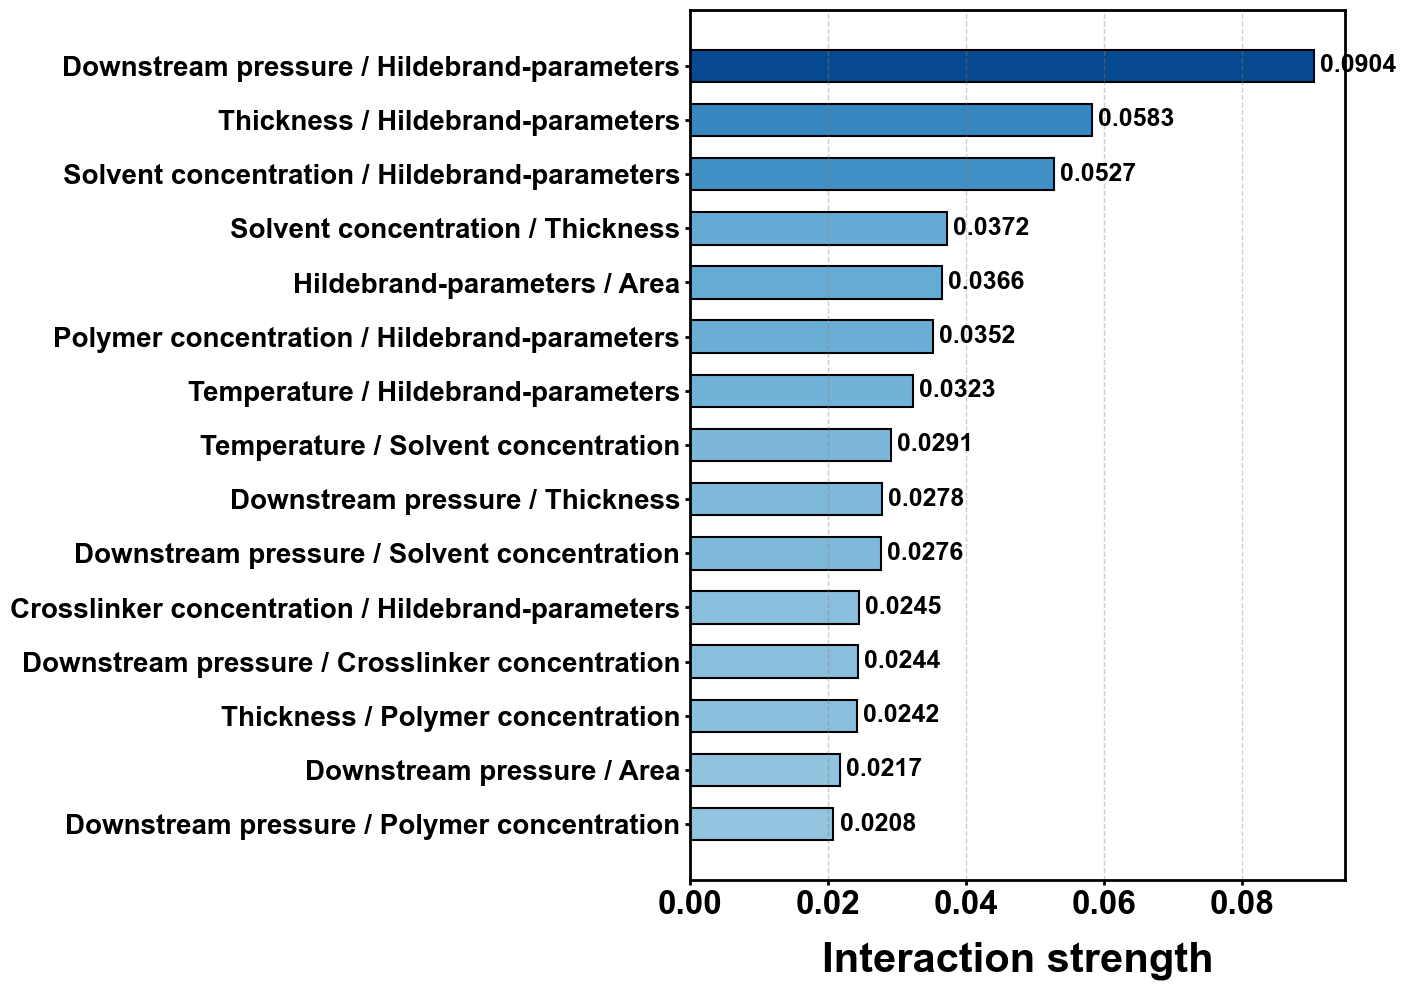

In [5]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import xgboost as xgb
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split

# ==========================================
# 0. Environment Setup & Data Loading
# ==========================================
print("🔄 Initializing environment and reconstructing Separation Factor model...")

# 1. Load Data
sf_file_path = 'C:/Users/tinid/polymer/major revision/标准化数据_无独热_Log变换12.18.csv'
try:
    data_sf = pd.read_csv(sf_file_path)
except FileNotFoundError:
    print(f"❌ Error: File not found {sf_file_path}")
    exit()

# 2. Define Target & Features
excluded_cols = ['log_Separation factor', 'polymer', 'DOI', 'Flux', 'log_Flux', 'Separation factor']
X_sf = data_sf.drop(columns=excluded_cols, errors='ignore')
y_sf = data_sf['log_Separation factor']

# 3. Identify Categorical Features
categorical_features = ['Permeation type']
categorical_features = [c for c in categorical_features if c in X_sf.columns]

# 4. Split Data
X_train_sf, _, y_train_sf, _ = train_test_split(X_sf, y_sf, test_size=0.2, random_state=42)

# 5. One-Hot Encoding
X_train_sf_encoded = pd.get_dummies(X_train_sf, columns=categorical_features, drop_first=False)

# 6. Train XGBoost Model
model_sf = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42, n_jobs=-1)
model_sf.fit(X_train_sf_encoded, y_train_sf)

print("✅ Model and data ready.")

# ==========================================
# 9. SHAP Interaction Analysis (ALL PAIRS)
# ==========================================
print("\n📊 Starting SHAP Interaction Analysis for ALL pairs...")

# 1. Prepare Sample Data
X_target = X_train_sf_encoded
sample_size = min(500, len(X_target))
X_sample_df = X_target.sample(n=sample_size, random_state=42)
feature_names_clean = list(X_sample_df.columns)
n_features = len(feature_names_clean)

# 2. Calculate SHAP Interaction Values
print("   Calculating SHAP interaction matrix (this may take time)...")
explainer = shap.TreeExplainer(model_sf)
# Shape: (samples, n_features, n_features)
shap_interaction_values = explainer.shap_interaction_values(X_sample_df)

# 3. Calculate Strength for ALL Pairs
# ------------------------------------------
interaction_data = []

print(f"   Calculating interaction strength for all feature pairs...")

# Double loop to traverse all unique pairs
for i in range(n_features):
    for j in range(i + 1, n_features):
        idx1 = i
        idx2 = j
        
        name1 = feature_names_clean[idx1]
        name2 = feature_names_clean[idx2]
        
        # Strength calculation: mean(|Off-diagonal|) * 2
        strength = np.abs(shap_interaction_values[:, idx1, idx2]).mean() * 2
        
        interaction_data.append({
            'Feature 1': name1,
            'Feature 2': name2,
            'Pair': f"{name1} / {name2}", # For CSV readability
            'Strength': strength
        })

# Convert to DataFrame and Sort
df_interaction = pd.DataFrame(interaction_data)
df_interaction = df_interaction.sort_values(by='Strength', ascending=True) 

# ==========================================
# 4. Save to CSV (All Values)
# ==========================================
output_dir = 'C:/Users/tinid/polymer/major revision/'
os.makedirs(output_dir, exist_ok=True)

csv_path = os.path.join(output_dir, 'SHAP_SF_All_Interaction_Values.csv')
df_interaction.to_csv(csv_path, index=False)
print(f"✅ All interaction values saved to: {csv_path}")

# Print Top 20 to console for quick check
print("\n--- Top 20 Strongest Interactions (Separation Factor) ---")
print(df_interaction.tail(20)[['Pair', 'Strength']].sort_values(by='Strength', ascending=False))

# ==========================================
# 5. Plotting (Top 15 Only)
# ==========================================
# Filter top 15 for plotting to keep it readable
df_plot = df_interaction.tail(15).copy()

# Global Style Settings (High Contrast)
plt.style.use('default')
plt.rcParams.update({
    'font.family': ['Arial', 'DejaVu Sans', 'sans-serif'],
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'axes.edgecolor': 'black',
    'axes.linewidth': 2.0,
    'xtick.color': 'black',
    'ytick.color': 'black',
    'text.color': 'black',
    'xtick.major.width': 2.0,
    'ytick.major.width': 2.0,
    'xtick.labelsize': 24,
    'ytick.labelsize': 24,
})

fig, ax = plt.subplots(figsize=(14, 10), facecolor='white')

# Dynamic Color Mapping
norm = mcolors.Normalize(vmin=df_plot['Strength'].min(), vmax=df_plot['Strength'].max())
colors = [plt.cm.Blues(0.4 + 0.5 * (val - df_plot['Strength'].min()) / (df_plot['Strength'].max() - df_plot['Strength'].min() + 1e-9)) for val in df_plot['Strength']]

# Bar Plot
bars = ax.barh(df_plot['Pair'], df_plot['Strength'], color=colors, edgecolor='black', linewidth=1.5, height=0.6)

# Labels
ax.set_xlabel("Interaction strength", fontsize=30, fontweight='bold', color='black', labelpad=15)
ax.set_ylabel("", fontsize=26, fontweight='bold', color='black')

# Ticks
plt.xticks(fontsize=24, fontweight='bold', color='black')
plt.yticks(fontsize=20, fontweight='bold', color='black') 

# Value Labels
for bar in bars:
    width = bar.get_width()
    label_x_pos = width + (df_plot['Strength'].max() * 0.01)
    ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, 
            f'{width:.4f}', 
            ha='left', va='center', fontsize=18, fontweight='bold', color='black')

# Spines
for spine in ax.spines.values():
    spine.set_linewidth(2.0)
    spine.set_color('black')

# Grid
ax.grid(axis='x', linestyle='--', alpha=0.4, color='gray', linewidth=1)

plt.tight_layout()

# Save Plot
save_name = os.path.join(output_dir, 'SHAP_SF_Interaction_Strength_Top15.png')
plt.savefig(save_name, dpi=300, bbox_inches='tight')
print(f"✅ Top 15 Interaction Plot saved to: {save_name}")

plt.show()

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.inspection import partial_dependence
from sklearn.model_selection import train_test_split
import matplotlib.colors as mcolors
import os

# ... (前面的数据加载、模型训练、环境重构代码保持不变，请确保已运行) ...
# ... (确保 model_sf, X_train_sf_encoded, raw_data_full 都在内存中) ...

# ==========================================
# 10. 绘制 2D PDP (清晰色块版 - Contourf)
# ==========================================
print("\n🎨 正在绘制 2D PDP (增强对比度与色块清晰度)...")
output_dir = 'C:/Users/tinid/polymer/major revision/PDP_2D_SF_Clear/'
os.makedirs(output_dir, exist_ok=True)

# 1. 准备交互对 (同前)
# ------------------------------------------------
num_feats = [c for c in X_train_sf_encoded.columns if c in raw_data_full.columns]
importance = model_sf.feature_importances_
feat_importance_pair = [(col, imp) for col, imp in zip(X_train_sf_encoded.columns, importance) if col in num_feats]
feat_importance_pair.sort(key=lambda x: x[1], reverse=True)
top_features = [x[0] for x in feat_importance_pair[:9]]
interaction_pairs = []
for i in range(len(top_features)):
    for j in range(i + 1, len(top_features)):
        interaction_pairs.append((top_features[i], top_features[j]))
interaction_pairs = interaction_pairs[:36]

# 2. 全局样式设置
# ------------------------------------------------
plt.style.use('default')
plt.rcParams.update({
    'font.family': ['Arial', 'DejaVu Sans', 'sans-serif'],
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'axes.edgecolor': 'black',
    'axes.linewidth': 2.0,
    'xtick.color': 'black', 'ytick.color': 'black', 'text.color': 'black',
    'xtick.major.width': 2.0, 'ytick.major.width': 2.0,
    'xtick.labelsize': 30, 'ytick.labelsize': 30
})

# 定义高对比度红蓝 Colormap
# 稍微加深两端颜色，增强视觉冲击力
colors = ["#1a2a6c", "#4c72b0", "#ffffff", "#c44e52", "#800000"] 
# 创建分段的 Colormap (分成 100 级以保证渐变，但在 contourf 中会被切分)
cmap_custom = mcolors.LinearSegmentedColormap.from_list("HighContrastRedBlue", colors, N=256)

# 3. 循环绘制
# ------------------------------------------------
for feat1, feat2 in interaction_pairs:
    
    # A. 计算 PDP
    pdp_results = partial_dependence(
        model_sf, X_train_sf_encoded, [feat1, feat2], 
        grid_resolution=50, kind='average'
    )
    Z = pdp_results['average'][0] 
    x_vals_std = pdp_results['values'][0]
    y_vals_std = pdp_results['values'][1]
    
    # B. 坐标轴还原
    def unscale_grid(feature_name, grid_std):
        if not raw_data_full.empty and feature_name in raw_data_full.columns:
            raw_series = raw_data_full[feature_name]
            mu = raw_series.mean()
            sigma = raw_series.std()
            return grid_std * sigma + mu
        else:
            return grid_std

    x_vals_raw = unscale_grid(feat1, x_vals_std)
    y_vals_raw = unscale_grid(feat2, y_vals_std)
    
    # 【核心修改】构建网格矩阵 (Contourf 需要网格数据)
    X_grid, Y_grid = np.meshgrid(x_vals_raw, y_vals_raw)
    
    # C. 绘图
    fig, ax = plt.subplots(figsize=(12, 10), facecolor='white')
    
    # 【核心修改 1】使用 contourf 代替 imshow
    # levels=20: 将数值范围切分成 20 个明显的色阶，色块感更强
    cntr = ax.contourf(
        X_grid, Y_grid, Z.T, 
        levels=20,           # 增加层级数可以让过渡更自然但又能看清边界
        cmap=cmap_custom, 
        extend='both'        # 处理超出范围的颜色
    )
    
    # 【核心修改 2】关闭 imshow 的平滑，改为叠加极细的等高线 (可选)
    # 这能让色块的边界更加锐利
    # ax.contour(X_grid, Y_grid, Z.T, levels=20, colors='black', linewidths=0.2, alpha=0.3)

    # D. 样式应用
    ax.set_xlabel(feat1, fontsize=40, fontweight='bold', labelpad=15)
    ax.set_ylabel(feat2, fontsize=40, fontweight='bold', labelpad=15)
    
    # Colorbar (配合 Contourf)
    cbar = plt.colorbar(cntr, ax=ax, pad=0.05)
    cbar.set_label('Prediction value', fontsize=34, fontweight='bold', labelpad=15)
    # 强制将 Colorbar 的刻度也加粗
    cbar.ax.tick_params(labelsize=32, width=2)
    cbar.outline.set_linewidth(2)
    # 移除 colorbar 内部的分割线，让它看起来像一条连续但有层次的带子
    cbar.solids.set_edgecolor("face")

    # 边框与刻度
    for spine in ax.spines.values():
        spine.set_linewidth(2.0)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

    plt.tight_layout()
    
    safe_name = f"{feat1}_vs_{feat2}".replace(" ", "_").replace("/", "_")
    save_path = os.path.join(output_dir, f'PDP_2D_Clear_{safe_name}.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✅ 图表已保存: {save_path}")
    
    plt.show()

print("\n清晰版 2D PDP 绘制完成！")


🎨 正在绘制 2D PDP (增强对比度与色块清晰度)...


NameError: name 'raw_data_full' is not defined

🔄 正在切换环境至：分离因子 (Separation Factor) 分析模式...
✅ 分离因子模型已准备就绪。
📊 正在计算分离因子的 SHAP 值...

🚀 正在绘制分离因子 (SF) 的单因素依赖图 (无拟合线)...
✅ 原始数据加载成功，用于数值还原。
分离因子最重要的特征: ['Hildebrand parameter', 'Downstream pressure', 'Solvent concentration', 'Polymer concentration', 'Thickness', 'Crosslinker concentration', 'Temperature', 'Area', 'Monomer molecular weight']
✅ 已保存: SHAP_SF_Hildebrand_parameter_NoFit.png


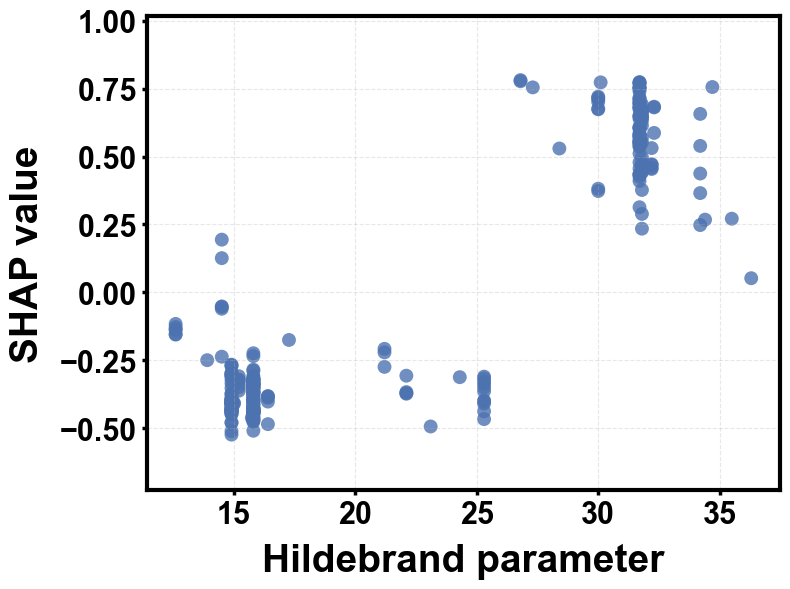

✅ 已保存: SHAP_SF_Downstream_pressure_NoFit.png


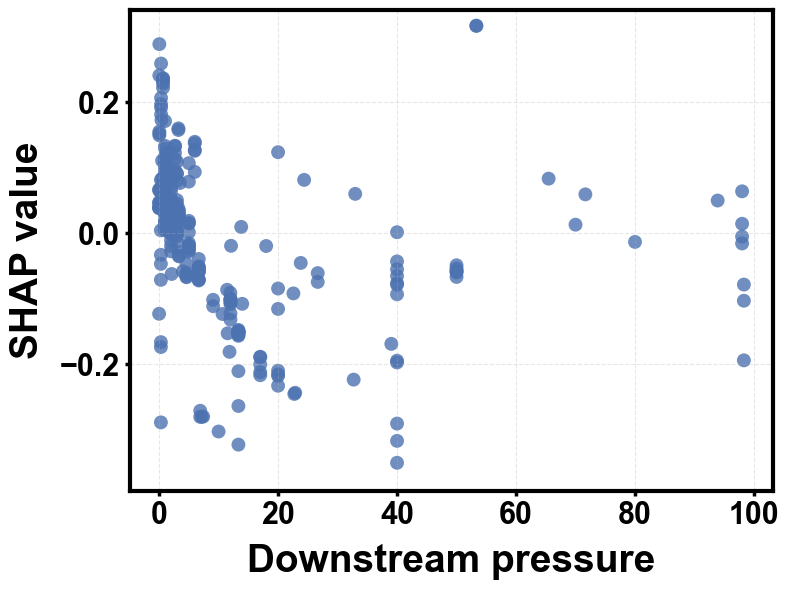

✅ 已保存: SHAP_SF_Solvent_concentration_NoFit.png


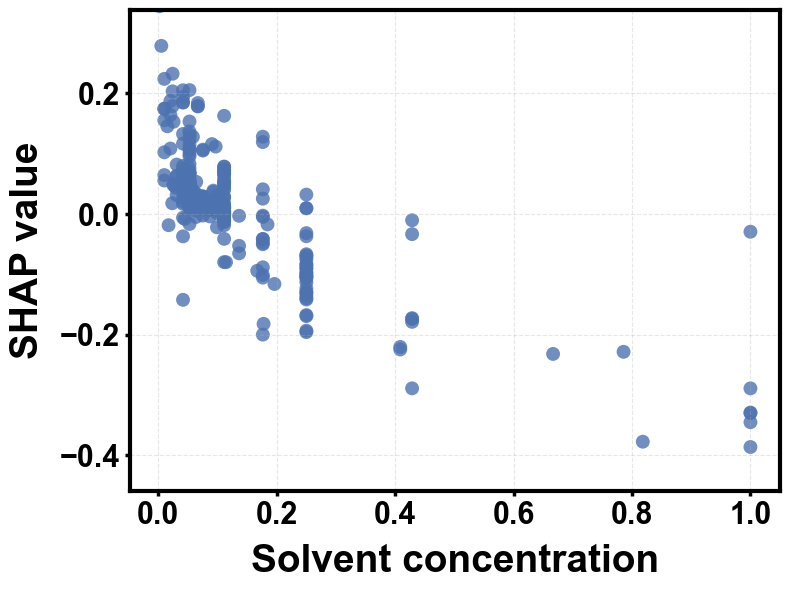

✅ 已保存: SHAP_SF_Polymer_concentration_NoFit.png


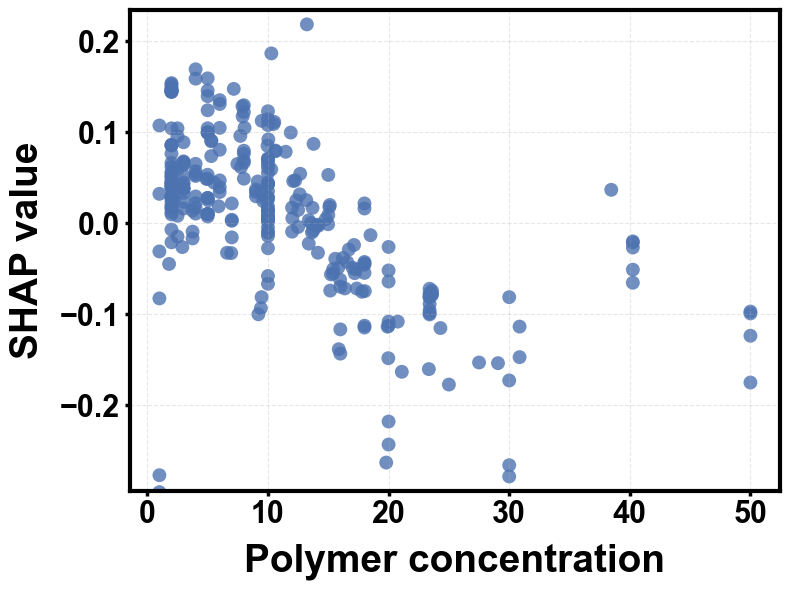

✅ 已保存: SHAP_SF_Thickness_NoFit.png


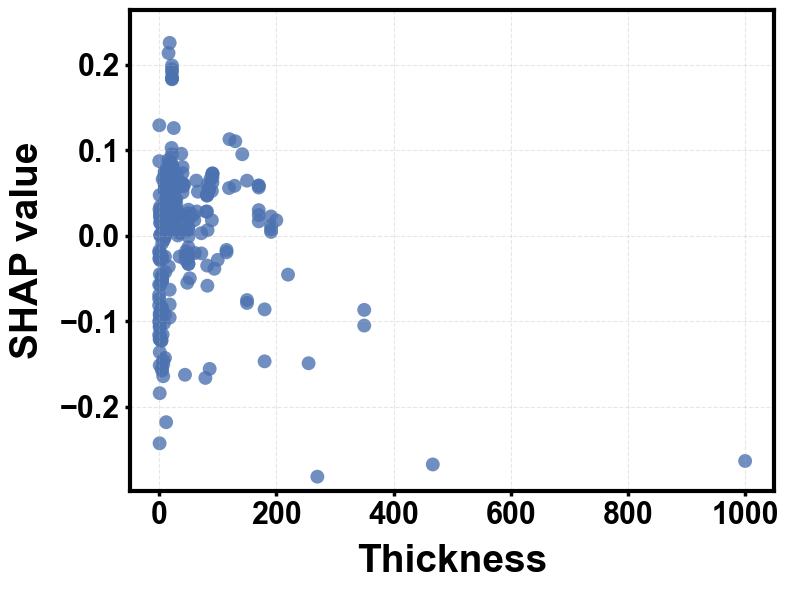

✅ 已保存: SHAP_SF_Crosslinker_concentration_NoFit.png


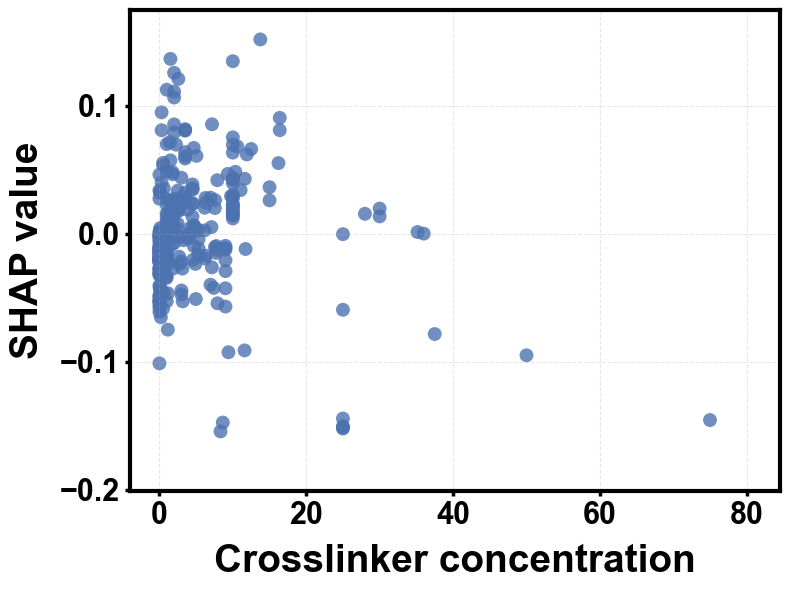

✅ 已保存: SHAP_SF_Temperature_NoFit.png


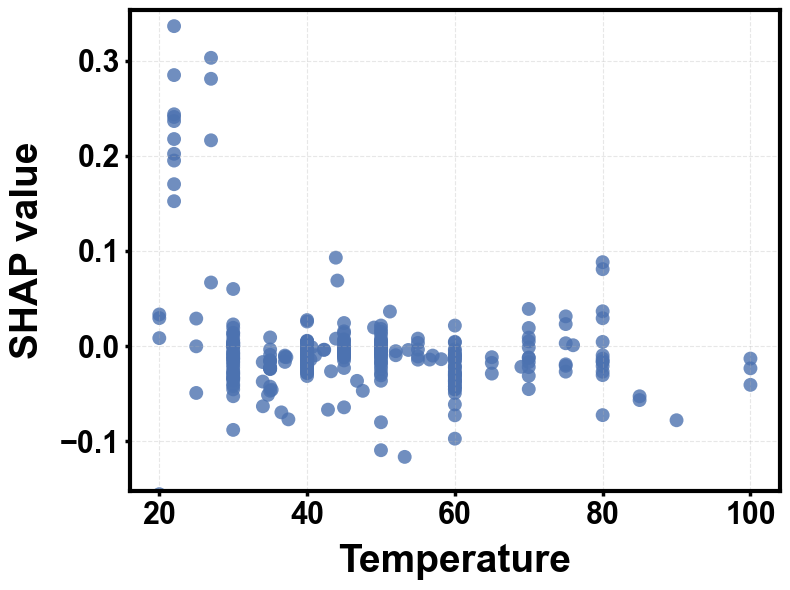

✅ 已保存: SHAP_SF_Area_NoFit.png


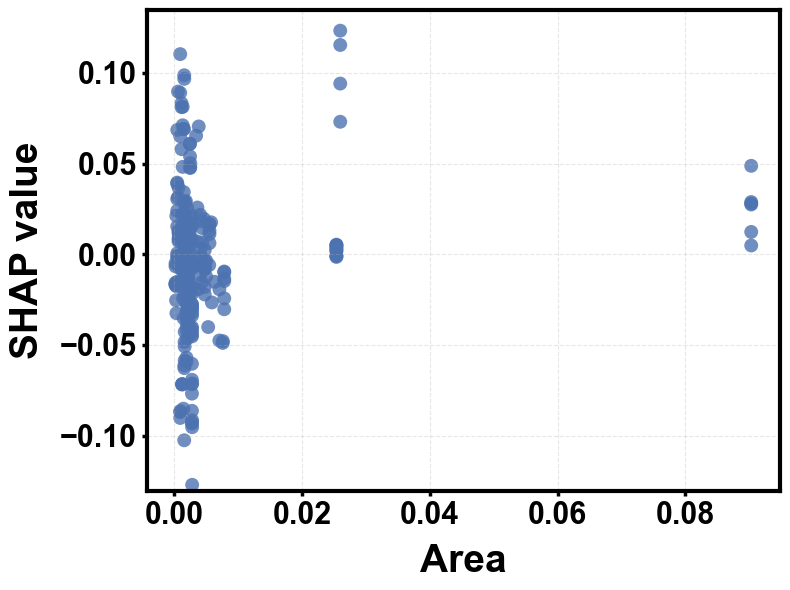

✅ 已保存: SHAP_SF_Monomer_molecular_weight_NoFit.png


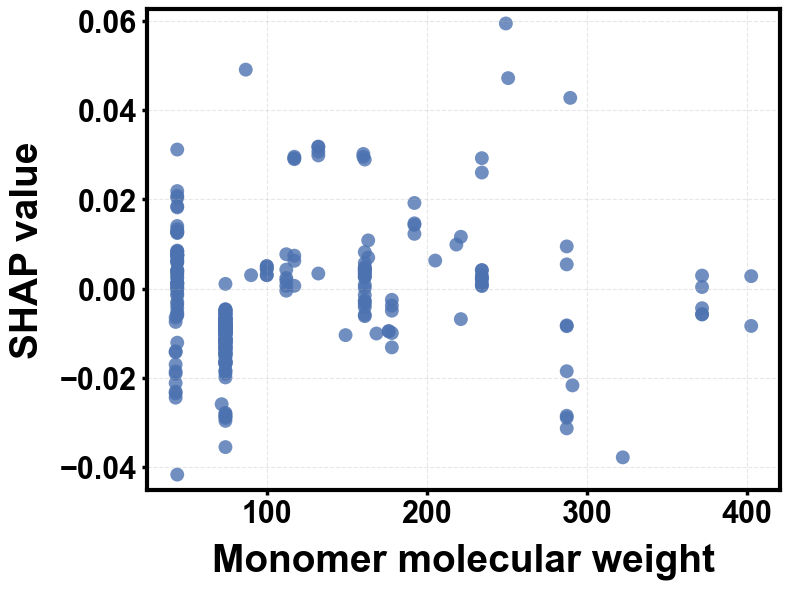


分离因子 (SF) 单因素图 (无拟合线) 绘制完成！


In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shap
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# ==========================================
# 0. 重新加载分离因子数据与模型 (确保上下文正确)
# ==========================================
print("🔄 正在切换环境至：分离因子 (Separation Factor) 分析模式...")

# 1. 加载分离因子专用数据
sf_file_path = 'C:/Users/tinid/polymer/major revision/标准化数据_无独热_Log变换12.18.csv'
data_sf = pd.read_csv(sf_file_path)

# 2. 定义目标与特征 (排除 Flux)
# 注意：这里我们预测 log_Separation factor
excluded_cols = ['log_Separation factor', 'polymer', 'DOI', 'Flux', 'log_Flux', 'Separation factor']
X_sf = data_sf.drop(columns=excluded_cols, errors='ignore')
y_sf = data_sf['log_Separation factor']

# 3. 重新识别特征
categorical_features = ['Permeation type']
categorical_features = [c for c in categorical_features if c in X_sf.columns]
numerical_features_sf = [c for c in X_sf.columns if c not in categorical_features]

# 4. 划分训练集 (保持 random_state=42 以复现之前的划分)
X_train_sf, _, y_train_sf, _ = train_test_split(X_sf, y_sf, test_size=0.2, random_state=42)

# 5. 快速重新训练 XGBoost 模型 (使用之前分离因子的最佳参数)
model_sf = xgb.XGBRegressor(
    n_estimators=500, 
    learning_rate=0.05, 
    max_depth=6, 
    random_state=42, 
    n_jobs=-1
)
# 手动做一下 OneHot 对应的 get_dummies
X_train_sf_encoded = pd.get_dummies(X_train_sf, columns=categorical_features, drop_first=False)
model_sf.fit(X_train_sf_encoded, y_train_sf)

print("✅ 分离因子模型已准备就绪。")

# 6. 计算分离因子的 SHAP 值
print("📊 正在计算分离因子的 SHAP 值...")
explainer_sf = shap.TreeExplainer(model_sf)
shap_values_sf = explainer_sf.shap_values(X_train_sf_encoded)

# ==========================================
# 7. 单因素 SHAP 依赖图 (分离因子专用版 - 无拟合线)
# ==========================================
print("\n🚀 正在绘制分离因子 (SF) 的单因素依赖图 (无拟合线)...")

# 1. 输出目录 (修改为 SF)
output_dir = 'C:/Users/tinid/polymer/major revision/SHAP_Dependence_SF_Sampled_NoFit/'
os.makedirs(output_dir, exist_ok=True)

# 2. 加载原始 MICE 数据以还原数值
raw_file_path = 'C:/Users/tinid/polymer/major revision/MICE填补12.18.csv'
try:
    raw_data_full = pd.read_csv(raw_file_path)
    # 修复列名
    if 'Hildebrand-parameters' in raw_data_full.columns:
        raw_data_full.rename(columns={'Hildebrand-parameters': 'Hildebrand parameter'}, inplace=True) 
    # 再次检查
    if 'Hildebrand parameter' not in raw_data_full.columns and 'Hildebrand parameters' in raw_data_full.columns:
         raw_data_full.rename(columns={'Hildebrand parameters': 'Hildebrand parameter'}, inplace=True)
         
    print(f"✅ 原始数据加载成功，用于数值还原。")
except Exception as e:
    print(f"❌ 警告: 无法加载原始数据 ({e})，将使用标准化数值。")
    raw_data_full = pd.DataFrame()

# 全局样式设置
plt.style.use('default')
plt.rcParams.update({
    'font.family': 'Arial', 'font.weight': 'bold', 'text.color': 'black',
    'axes.labelweight': 'bold', 'axes.titleweight': 'bold',
    'axes.labelcolor': 'black', 'axes.edgecolor': 'black', 'axes.linewidth': 3,
    'xtick.color': 'black', 'ytick.color': 'black',
    'xtick.major.width': 2.5, 'ytick.major.width': 2.5,
    'xtick.labelsize': 22, 'ytick.labelsize': 22,
})

# 3. 筛选 Top 数值特征 (基于分离因子的 SHAP)
valid_num_features = [f for f in numerical_features_sf if f in X_train_sf_encoded.columns]
feat_indices_map = {name: i for i, name in enumerate(X_train_sf_encoded.columns)}
selected_indices = [feat_indices_map[f] for f in valid_num_features]

# 计算重要性并排序
mean_shap = np.mean(np.abs(shap_values_sf[:, selected_indices]), axis=0)
top_local_indices = np.argsort(mean_shap)[-10:][::-1] # 取前10个
top_features = [valid_num_features[i] for i in top_local_indices]

print(f"分离因子最重要的特征: {top_features}")

# 4. 降采样设置
n_points = 300
total = len(X_train_sf)
if total > n_points:
    np.random.seed(42)
    sample_idx = np.random.choice(total, n_points, replace=False)
else:
    sample_idx = np.arange(total)

# 5. 循环绘制
scatter_color = '#4c72b0'

for feature in top_features:
    # A. 准备 X 轴数据 (原始值)
    x_data = None
    if not raw_data_full.empty and feature in raw_data_full.columns:
        try:
            # 对齐索引
            full_vals = raw_data_full.loc[X_train_sf.index, feature].values
            x_data = full_vals[sample_idx]
        except:
            pass
    
    # 如果没找到原始值，用训练数据
    if x_data is None:
        # 从编码后的训练集中取
        x_data = X_train_sf_encoded.iloc[sample_idx][feature].values

    # B. 准备 Y 轴数据 (SHAP)
    col_idx = feat_indices_map[feature]
    y_data = shap_values_sf[sample_idx, col_idx]

    # C. 绘图
    fig, ax = plt.subplots(figsize=(8, 6), facecolor='white')
    ax.scatter(x_data, y_data, color=scatter_color, s=100, alpha=0.8, edgecolors='none')

    # D. 趋势线 (已移除)
    # 此处原有的 lowess 代码块已被删除

    # E. 样式
    ax.set_xlabel(feature, fontsize=28, fontweight='bold', labelpad=10)
    ax.set_ylabel("SHAP value", fontsize=28, fontweight='bold', labelpad=10)
    
    # 自动缩放 Y 轴 (去极值)
    y_lo, y_hi = np.percentile(y_data, 2), np.percentile(y_data, 98)
    margin = (y_hi - y_lo) * 0.2
    if y_hi > y_lo:
        ax.set_ylim(y_lo - margin, y_hi + margin)
        
    ax.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()

    # 保存
    safe_name = feature.replace(" ", "_").replace("/", "_")
    plt.savefig(os.path.join(output_dir, f'SHAP_SF_{safe_name}_NoFit.png'), dpi=300)
    print(f"✅ 已保存: SHAP_SF_{safe_name}_NoFit.png")
    plt.show()

print("\n分离因子 (SF) 单因素图 (无拟合线) 绘制完成！")

In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import clone # 用于克隆模型配置

# ==========================================
# 1. 加载与预处理
# ==========================================
file_path = 'C:/Users/tinid/polymer/major revision/通量标准化数据_无独热_Log变换12.18.csv'

try:
    data = pd.read_csv(file_path)
    print(f"✅ 成功加载数据，共 {len(data)} 行。")
except FileNotFoundError:
    try:
        # 备用尝试：如果路径中有特殊字符，尝试用 gbk 读取
        data = pd.read_csv(file_path, encoding='gbk')
        print(f"✅ 成功加载数据 (GBK)，共 {len(data)} 行。")
    except Exception as e:
        print(f"❌ 错误：无法读取文件。{e}")
        exit()

excluded_columns = ['log_Flux', 'polymer', 'DOI', 'Separation factor']
X = data.drop(columns=excluded_columns, errors='ignore')
y = data['log_Flux']

# 预处理
numerical_features = X.columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ])

# 划分数据 (80% 用于训练/调优/CV, 20% 用于最终独立测试)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 应用预处理 (注意：CV过程中通常建议在Pipeline中处理以防泄漏，但按你原代码逻辑在此处处理)
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

print(f"训练集形状: {X_train_processed.shape}")
print("正在启动超参数优化... (这可能需要几分钟)")

# ==========================================
# 2. 定义超参数搜索空间
# ==========================================
param_dist = {
    'n_estimators': [500, 1000, 1500, 2000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 8],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 0.5, 1],
    'reg_lambda': [0.1, 1, 5, 10],
    'gamma': [0, 0.1, 0.2, 0.5]
}

# ==========================================
# 3. 配置随机搜索 (改为 10 折)
# ==========================================
xgb_base = xgb.XGBRegressor(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=50,
    scoring='r2',
    cv=10,            # <--- 修改为 10 折
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_processed, y_train)

# ==========================================
# 4. 输出最优参数
# ==========================================
best_model = random_search.best_estimator_
print("\n" + "="*40)
print(f"🎉 最佳参数组合找到！(CV 平均 R2: {random_search.best_score_:.4f})")
print("="*40)
print(random_search.best_params_)

# ==========================================
# 4.5 [新增] 输出每一折的详细结果
# ==========================================
print("\n" + "="*40)
print(">>> 正在生成十折交叉验证详细报告 (Per-Fold Results)...")
print("="*40)

kf = KFold(n_splits=10, shuffle=True, random_state=42)
fold_results = []

# 重置索引以确保 iloc 切片正确
y_train_reset = y_train.reset_index(drop=True)

# 注意：X_train_processed 是 numpy array，不需要 reset_index
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_processed)):
    # 切分数据
    X_k_train, X_k_val = X_train_processed[train_idx], X_train_processed[val_idx]
    y_k_train, y_k_val = y_train_reset.iloc[train_idx], y_train_reset.iloc[val_idx]
    
    # 克隆最佳模型配置进行独立训练
    model = clone(best_model)
    model.fit(X_k_train, y_k_train)
    
    # 预测
    y_train_pred = model.predict(X_k_train)
    y_val_pred = model.predict(X_k_val)
    
    # 记录指标
    fold_results.append({
        'Fold': fold + 1,
        'Train R2': r2_score(y_k_train, y_train_pred),
        'Train RMSE': np.sqrt(mean_squared_error(y_k_train, y_train_pred)),
        'Train MAE': mean_absolute_error(y_k_train, y_train_pred),
        'Val R2': r2_score(y_k_val, y_val_pred),
        'Val RMSE': np.sqrt(mean_squared_error(y_k_val, y_val_pred)),
        'Val MAE': mean_absolute_error(y_k_val, y_val_pred)
    })

# 输出表格
df_fold_results = pd.DataFrame(fold_results)
# 添加平均值行
df_fold_results.loc['Average'] = df_fold_results.mean()
# 格式化输出
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(df_fold_results.round(4))


# ==========================================
# 5. 全面性能评估 (最终测试集)
# ==========================================
print("\n正在计算最终独立测试集指标...")

# --- A. 预测 (Log尺度) ---
y_train_pred_log = best_model.predict(X_train_processed)
y_val_pred_log = best_model.predict(X_val_processed)

# --- B. 还原 (Original尺度: 10^y) ---
y_train_real = 10 ** y_train
y_train_pred_real = 10 ** y_train_pred_log

y_val_real = 10 ** y_val
y_val_pred_real = 10 ** y_val_pred_log

# --- C. 定义计算函数 ---
def calculate_metrics(y_true, y_pred, label):
    return {
        'Dataset': label,
        'R2': r2_score(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred)
    }

# --- D. 计算四组指标 ---
metrics_list = [
    calculate_metrics(y_train, y_train_pred_log, 'Train (Log Scale)'),
    calculate_metrics(y_val, y_val_pred_log,   'Test  (Log Scale)'), # 这里实际上是 Hold-out Test set
    calculate_metrics(y_train_real, y_train_pred_real, 'Train (Original)'),
    calculate_metrics(y_val_real, y_val_pred_real,   'Test  (Original)')
]

# --- E. 转换为 DataFrame 并展示 ---
results_df = pd.DataFrame(metrics_list)

print("\n" + "="*60)
print("             🚀 模型综合性能评估报告 🚀")
print("="*60)
# 格式化输出：保留4位小数
print(results_df.round(4).to_string(index=False))
print("-" * 60)

# --- F. 过拟合快速诊断 ---
train_r2 = results_df.loc[0, 'R2']
val_r2 = results_df.loc[1, 'R2']
gap = train_r2 - val_r2

print(f"\n[过拟合诊断]: R2 差距 = {gap:.4f}")
if gap > 0.15:
    print("⚠️ 警告: 模型可能存在过拟合 (差距 > 0.15)。")
    print("建议: 尝试降低 max_depth, 增加 reg_alpha/reg_lambda, 或减少 n_estimators。")
else:
    print("✅ 状态良好: 训练集与验证集差距在合理范围内。")

✅ 成功加载数据，共 791 行。
训练集形状: (632, 10)
正在启动超参数优化... (这可能需要几分钟)
Fitting 10 folds for each of 50 candidates, totalling 500 fits

🎉 最佳参数组合找到！(CV 平均 R2: 0.7343)
{'subsample': 0.9, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 1500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0}

>>> 正在生成十折交叉验证详细报告 (Per-Fold Results)...
         Fold  Train R2  Train RMSE  Train MAE  Val R2  Val RMSE  Val MAE
0         1.0    0.9988      0.0217     0.0160  0.4533    0.4401   0.2351
1         2.0    0.9986      0.0237     0.0164  0.8603    0.2155   0.1598
2         3.0    0.9985      0.0246     0.0171  0.4788    0.3915   0.2289
3         4.0    0.9984      0.0245     0.0175  0.6804    0.4260   0.2579
4         5.0    0.9985      0.0241     0.0173  0.7065    0.3468   0.2378
5         6.0    0.9984      0.0248     0.0179  0.8548    0.2332   0.1625
6         7.0    0.9985      0.0243     0.0172  0.7604    0.2753   0.1886
7         8.0    0.9986      0.0231     0.0163  0.7944    0.255

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.inspection import partial_dependence
from sklearn.model_selection import train_test_split
import matplotlib.colors as mcolors
import os

# ==========================================
# 0. 数据加载与预处理 (修复 NameError 的关键)
# ==========================================
# 【重要】请修改此处的路径为您的原始数据路径
csv_path = 'C:/Users/tinid/polymer/major revision/MICE填补12.18.csv'
raw_data_full = pd.read_csv(csv_path)

# 假设 model_sf 和 X_train_sf_encoded 已经在之前的步骤中训练好了
# 如果没有，请确保在此处已经有了这两个变量
# 为了演示代码运行，这里做一个简单的检查：
if 'model_sf' not in locals() or 'X_train_sf_encoded' not in locals():
    print("⚠️ 警告: model_sf 或 X_train_sf_encoded 未定义。")
    print("请确保在运行此段代码前，已经运行了模型训练代码。")
    # 如果您是单独运行此段，您需要在这里重新加载模型和训练集
    # X = ...
    # model_sf = ...

# ==========================================
# 10. 绘制 2D PDP (清晰色块版 - Contourf)
# ==========================================
print("\n🎨 正在绘制 2D PDP (增强对比度与色块清晰度)...")
output_dir = 'C:/Users/tinid/polymer/major revision/PDP_2D_SF_Clear/'
os.makedirs(output_dir, exist_ok=True)

# 1. 准备交互对
# ------------------------------------------------
# 确保只选择在原始数据中存在的列进行还原
num_feats = [c for c in X_train_sf_encoded.columns if c in raw_data_full.columns]

importance = model_sf.feature_importances_
feat_importance_pair = [(col, imp) for col, imp in zip(X_train_sf_encoded.columns, importance) if col in num_feats]
feat_importance_pair.sort(key=lambda x: x[1], reverse=True)

top_features = [x[0] for x in feat_importance_pair[:9]]
interaction_pairs = []
for i in range(len(top_features)):
    for j in range(i + 1, len(top_features)):
        interaction_pairs.append((top_features[i], top_features[j]))
interaction_pairs = interaction_pairs[:36]

# 2. 全局样式设置
# ------------------------------------------------
plt.style.use('default')
plt.rcParams.update({
    'font.family': 'Arial',  # 优先使用 Arial
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'axes.edgecolor': 'black',
    'axes.linewidth': 2.0,
    'xtick.color': 'black', 'ytick.color': 'black', 'text.color': 'black',
    'xtick.major.width': 2.0, 'ytick.major.width': 2.0,
    'xtick.labelsize': 30, 'ytick.labelsize': 30
})

# 定义高对比度红蓝 Colormap
colors = ["#1a2a6c", "#4c72b0", "#ffffff", "#c44e52", "#800000"] 
cmap_custom = mcolors.LinearSegmentedColormap.from_list("HighContrastRedBlue", colors, N=256)

# 3. 循环绘制
# ------------------------------------------------
# 定义还原函数 (移动到循环外更高效)
def unscale_grid(feature_name, grid_std, raw_df):
    """
    将标准化/归一化的网格坐标还原为原始物理单位
    """
    if feature_name in raw_df.columns:
        raw_series = raw_df[feature_name]
        mu = raw_series.mean()
        sigma = raw_series.std()
        # 假设使用的是 StandardScaler (x = (x_raw - mu) / sigma)
        # 如果您使用的是 MinMaxScaler，请改为: return grid_std * (max - min) + min
        return grid_std * sigma + mu
    else:
        return grid_std

for feat1, feat2 in interaction_pairs:
    
    # A. 计算 PDP
    # 注意：grid_resolution 越高，contourf 的边缘越平滑，但计算越慢
    pdp_results = partial_dependence(
        model_sf, X_train_sf_encoded, [feat1, feat2], 
        grid_resolution=50, kind='average'
    )
    Z = pdp_results['average'][0] 
    x_vals_std = pdp_results['values'][0]
    y_vals_std = pdp_results['values'][1]
    
    # B. 坐标轴还原
    x_vals_raw = unscale_grid(feat1, x_vals_std, raw_data_full)
    y_vals_raw = unscale_grid(feat2, y_vals_std, raw_data_full)
    
    # 构建网格矩阵
    X_grid, Y_grid = np.meshgrid(x_vals_raw, y_vals_raw)
    
    # C. 绘图
    fig, ax = plt.subplots(figsize=(12, 10), facecolor='white')
    
    # 使用 contourf 绘制填充色块
    cntr = ax.contourf(
        X_grid, Y_grid, Z.T, 
        levels=20,           # 色阶层数
        cmap=cmap_custom, 
        extend='both'
    )
    
    # D. 样式应用
    ax.set_xlabel(feat1, fontsize=46, fontweight='bold', labelpad=15)
    ax.set_ylabel(feat2, fontsize=46, fontweight='bold', labelpad=15)
    
    # Colorbar 设置
    cbar = plt.colorbar(cntr, ax=ax, pad=0.05)
    cbar.set_label('Prediction value', fontsize=34, fontweight='bold', labelpad=15)
    cbar.ax.tick_params(labelsize=34, width=2)
    cbar.outline.set_linewidth(2)
    cbar.solids.set_edgecolor("face") # 消除色块间的细线

    # 边框与刻度
    for spine in ax.spines.values():
        spine.set_linewidth(2.0)
    
    # 格式化坐标轴刻度 (可选：保留2位小数)
    # from matplotlib.ticker import FormatStrFormatter
    # ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    # ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    plt.tight_layout()
    
    safe_name = f"{feat1}_vs_{feat2}".replace(" ", "_").replace("/", "_")
    save_path = os.path.join(output_dir, f'PDP_2D_Clear_{safe_name}.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    # 为了避免输出太多图卡顿，只打印保存信息，关闭显示
    # plt.show() 
    plt.close() # 关闭图形释放内存
    print(f"✅ 已保存: {safe_name}")

print(f"\n🎉 所有图表已保存至: {output_dir}")


🎨 正在绘制 2D PDP (增强对比度与色块清晰度)...


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


✅ 已保存: Thickness_vs_Downstream_pressure


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


✅ 已保存: Thickness_vs_Solvent_concentration


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


✅ 已保存: Thickness_vs_Area


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


✅ 已保存: Thickness_vs_Polymer_concentration


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


✅ 已保存: Thickness_vs_Monomer_molecular_weight


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


✅ 已保存: Thickness_vs_Temperature


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


✅ 已保存: Thickness_vs_Crosslinker_concentration


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


✅ 已保存: Downstream_pressure_vs_Solvent_concentration


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


✅ 已保存: Downstream_pressure_vs_Area


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


✅ 已保存: Downstream_pressure_vs_Polymer_concentration


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


✅ 已保存: Downstream_pressure_vs_Monomer_molecular_weight


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


✅ 已保存: Downstream_pressure_vs_Temperature


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


✅ 已保存: Downstream_pressure_vs_Crosslinker_concentration


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


✅ 已保存: Solvent_concentration_vs_Area


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


✅ 已保存: Solvent_concentration_vs_Polymer_concentration


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


✅ 已保存: Solvent_concentration_vs_Monomer_molecular_weight


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


✅ 已保存: Solvent_concentration_vs_Temperature


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


✅ 已保存: Solvent_concentration_vs_Crosslinker_concentration


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


✅ 已保存: Area_vs_Polymer_concentration


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


✅ 已保存: Area_vs_Monomer_molecular_weight


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


✅ 已保存: Area_vs_Temperature


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


✅ 已保存: Area_vs_Crosslinker_concentration


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


✅ 已保存: Polymer_concentration_vs_Monomer_molecular_weight


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


✅ 已保存: Polymer_concentration_vs_Temperature


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


✅ 已保存: Polymer_concentration_vs_Crosslinker_concentration


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


✅ 已保存: Monomer_molecular_weight_vs_Temperature


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


✅ 已保存: Monomer_molecular_weight_vs_Crosslinker_concentration


C:\Users\tinid\anaconda3\Lib\site-packages\sklearn\utils\_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(


✅ 已保存: Temperature_vs_Crosslinker_concentration

🎉 所有图表已保存至: C:/Users/tinid/polymer/major revision/PDP_2D_SF_Clear/
